In [1]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
# from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
import transformers
import pickle
import pandas as pd

In [20]:
import transformers


In [21]:
transformers.__version__

'2.1.1'

In [2]:
## distil-bert tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

In [4]:
with open('./source/wiki_fine_dtf.pickle', 'rb') as handle:
    dtf = pickle.load(handle)
# with open('./source/wiki_coarse_dtf.pickle', 'rb') as handle:
#     dtf = pickle.load(handle)

In [22]:
dtf.shape

(1196, 13)

In [5]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [6]:
import timeit

start_time = timeit.default_timer()

In [7]:
lst_stopwords = nltk.corpus.stopwords.words("english")
# lst_stopwords

In [8]:
dtf["text_clean"] = dtf["X"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
# dtf.head()

In [9]:
## split dataset
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3)
## get target
y_train = dtf_train["y"].values
y_test = dtf_test["y"].values

In [ ]:
# corpus = dtf_train["text_clean"]
# maxlen = 50

# ## add special tokens
# maxqnans = np.int((maxlen-20)/2)
# corpus_tokenized = ["[CLS] "+
#              " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
#              str(txt).lower().strip()))[:maxqnans])+
#              " [SEP] " for txt in corpus]

# ## generate masks
# masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(
#            txt.split(" "))) for txt in corpus_tokenized]
    
# ## padding
# txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]
    
# ## generate idx
# idx = [tokenizer.encode(seq.split(" ")) for seq in txt2seq]
    
# ## generate segments
# segments = [] 
# for seq in txt2seq:
#     temp, i = [], 0
#     for token in seq.split(" "):
#         temp.append(i)
#         if token == "[SEP]":
#              i += 1
#     segments.append(temp)
# ## feature matrix
# X_train = [np.asarray(idx, dtype='int32'), 
#            np.asarray(masks, dtype='int32'), 
#            np.asarray(segments, dtype='int32')]

In [10]:


def encode_data(corpus):
    maxlen = 50

    ## add special tokens
    maxqnans = np.int((maxlen-20)/2)
    corpus_tokenized = ["[CLS] "+
                 " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
                 str(txt).lower().strip()))[:maxqnans])+
                 " [SEP] " for txt in corpus]

    ## generate masks
    masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(
               txt.split(" "))) for txt in corpus_tokenized]

    ## padding
    txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]

    ## generate idx
    idx = [tokenizer.encode(seq.split(" ")) for seq in txt2seq]

    ## generate segments
    segments = [] 
    for seq in txt2seq:
        temp, i = [], 0
        for token in seq.split(" "):
            temp.append(i)
            if token == "[SEP]":
                 i += 1
        segments.append(temp)
    ## feature matrix
    result = [np.asarray(idx, dtype='int32'), 
               np.asarray(masks, dtype='int32'), 
               np.asarray(segments, dtype='int32')]
    return result
# corpus = dtf_test["text_clean"]
X_test =  encode_data(dtf_test["text_clean"])
X_train = encode_data(dtf_train["text_clean"])

In [11]:
## inputs
idx = layers.Input((50), dtype="int32", name="input_idx")
masks = layers.Input((50), dtype="int32", name="input_masks")
segments = layers.Input((50), dtype="int32", name="input_segments")
## pre-trained bert
nlp = transformers.TFBertModel.from_pretrained("bert-base-uncased")
bert_out, _ = nlp([idx, masks, segments])
## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(len(np.unique(y_train)), 
                     activation='softmax')(x)
## compile
model = models.Model([idx, masks, segments], y_out)
for layer in model.layers[:4]:
    layer.trainable = False
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_idx (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_segments (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 50, 768), (N 109482240   input_idx[0][0]                  
                                                                 input_masks[0][0]     

In [12]:
# ## inputs
# idx = layers.Input((50), dtype="int32", name="input_idx")
# masks = layers.Input((50), dtype="int32", name="input_masks")
# ## pre-trained bert with config
# config = transformers.DistilBertConfig(dropout=0.2, 
#            attention_dropout=0.2)
# config.output_hidden_states = False
# nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
# bert_out = nlp(idx, attention_mask=masks)[0]
# ## fine-tuning
# x = layers.GlobalAveragePooling1D()(bert_out)
# x = layers.Dense(64, activation="relu")(x)
# y_out = layers.Dense(len(np.unique(y_train)), 
#                      activation='softmax')(x)
# ## compile
# model = models.Model([idx, masks], y_out)
# for layer in model.layers[:3]:
#     layer.trainable = False
# model.compile(loss='sparse_categorical_crossentropy', 
#               optimizer='adam', metrics=['accuracy'])
# model.summary()

In [ ]:
# y_train

In [13]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## train
training = model.fit(x=X_train, y=y_train, batch_size=64, 
                     epochs=10, shuffle=True, verbose=1, 
                     validation_split=0.3)
## test


Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 2.1135 - accuracy: 0.3043

KeyboardInterrupt: 

In [15]:
elapsed = timeit.default_timer() - start_time
print (elapsed)

126.080844899


In [16]:
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

In [ ]:
# dic_y_mapping

Accuracy: 0.47
Auc: 0.85
Detail:
              precision    recall  f1-score   support

  basketball       0.00      0.00      0.00         6
        book       0.00      0.00      0.00         1
    football       0.00      0.00      0.00        14
       games       0.00      0.00      0.00        10
       media       0.00      0.00      0.00         2
       movie       0.00      0.00      0.00        30
       music       0.55      0.97      0.70        71
other sports       0.00      0.00      0.00        23
      racing       0.00      0.00      0.00        14
     science       0.76      0.20      0.32        65
      soccer       0.00      0.00      0.00        33
     society       0.40      1.00      0.57        86
      tennis       0.00      0.00      0.00         4

    accuracy                           0.47       359
   macro avg       0.13      0.17      0.12       359
weighted avg       0.34      0.47      0.33       359



/Users/weijiesun/anaconda3/envs/zdwenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


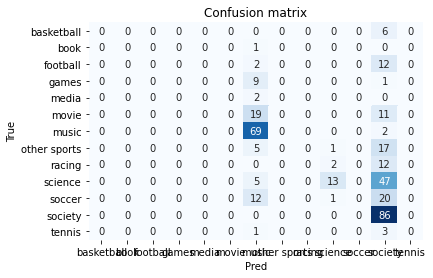

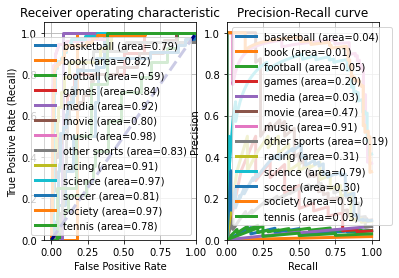

In [19]:
from sklearn import metrics 

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(list(y_test), list(predicted))
auc = metrics.roc_auc_score(y_test_array, predicted_prob, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
plt.savefig('bert_confusion_matrix.png')

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
# plt.show()
plt.savefig('auc.png')
